In [1]:
import numpy as np
from PIL import Image
import ctypes
import matplotlib.pyplot as plt
import random

In [2]:
asia = Image.open('test_images/asie/asia.jpg')
greek = Image.open('test_images/greek/greek.jpg')
chateau = Image.open('test_images/chateau/train_chateau.jpg')
predict_asia = Image.open('test_images/asie/predict_asie.jpg')
predict_greek = Image.open('test_images/greek/predict_grec.jpg')
predict_chateau = Image.open('test_images/chateau/predict_chateau.jpg')

In [3]:
newsize = (50,50)

In [4]:
asia_new_size = asia.resize(newsize)
greek_new_size = greek.resize(newsize)
chateau_new_size = chateau.resize(newsize)
predict_asia_new_size = predict_asia.resize(newsize)
predict_greek_new_size = predict_greek.resize(newsize)
predict_chateau_new_size = predict_chateau.resize(newsize)

In [5]:
# asia_new_size.show()
# greek_new_size.show()
# chateau_new_size.show()

In [6]:
asia_data = np.asarray(asia_new_size)
greek_data = np.asarray(greek_new_size)
chateau_data = np.asarray(predict_chateau_new_size)
predict_asia_data = np.asarray(predict_asia_new_size)
predict_greek_data = np.asarray(predict_greek_new_size)
predict_chateau_data = np.asarray(predict_chateau_new_size)

X = np.array([asia_data, greek_data, chateau_data], dtype=ctypes.c_float)
X_test = np.array([predict_asia_data, predict_greek_data, predict_chateau_data], dtype=ctypes.c_float)
X_flat = X.flatten()
X_flat = X_flat/255 * 2 - 1
# w_array = w_array/255 * 2 - 1

X_test_flat = X_test.flatten()
X_test_flat = X_test_flat/255 * 2 - 1

In [7]:
print(len(X_flat))

22500


In [8]:
print(len(X))

3


In [7]:
Y = np.array([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]], dtype=ctypes.c_float)
Y_flat = Y.flatten()
Y_test = np.array([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]], dtype=ctypes.c_float)
Y_test_flat = Y_test.flatten()
print(Y_flat)
print(Y_test_flat)

[ 1. -1. -1. -1.  1. -1. -1. -1.  1.]
[ 1. -1. -1. -1.  1. -1. -1. -1.  1.]


In [8]:
my_lib = ctypes.CDLL(r"..\rust_lib\target\release\rust_lib.dll")

my_lib.delete_float_array.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
]

my_lib.generate_random_mpl_w.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_int32]
my_lib.generate_random_mpl_w.restype = ctypes.POINTER(ctypes.c_float)

my_lib.delete_float_array.restype = None

layers = np.array([len(X_flat)/len(X), 16, 3], dtype=ctypes.c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
layers_pmc = (ctypes.c_float * len(layers))(*layers)
layers_ptr_pmc = ctypes.cast(layers_pmc, LP_c_float)

print(len(layers_pmc))
number_of_layers = len(layers_pmc)
print(layers)

3
[7.5e+03 1.6e+01 3.0e+00]


In [11]:
# w_array_ptr = my_lib.generate_random_mpl_w(layers_ptr_pmc, number_of_layers)
# w_array = np.ctypeslib.as_array(w_array_ptr, ((7501*3,))) #3*16 + 17*16 + 17*3
#
# LP_c_float = ctypes.POINTER(ctypes.c_float)
# x_to_predict = (ctypes.c_float * len(X_flat))(*X_flat)
# x_to_predict_ptr = ctypes.cast(x_to_predict, LP_c_float)
# LP_c_float = ctypes.POINTER(ctypes.c_float)
# y_to_predict = (ctypes.c_float * len(Y_flat))(*Y_flat)
# y_to_predict_ptr = ctypes.cast(y_to_predict, LP_c_float)
# my_lib.multi_layer_perceptron_training.argtypes = [
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.c_int32,
#     ctypes.c_int32,
#     ctypes.c_int32,
#     ctypes.c_float,
#     ctypes.c_int32,
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.c_int32,
#     ctypes.c_bool,
# ]
# my_lib.multi_layer_perceptron_training.restype = ctypes.POINTER(ctypes.c_float)

In [9]:
w_array_ptr = my_lib.generate_random_mpl_w(layers_ptr_pmc, number_of_layers)
w_array = np.ctypeslib.as_array(w_array_ptr, (7501*16 + 17*3,)) #3*16 + 17*16 + 17*3
print(w_array)
LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict = (ctypes.c_float * len(X_flat))(*X_flat)
x_to_predict_ptr = ctypes.cast(x_to_predict, LP_c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
y_to_predict = (ctypes.c_float * len(Y_flat))(*Y_flat)
y_to_predict_ptr = ctypes.cast(y_to_predict, LP_c_float)

LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict_test = (ctypes.c_float * len(X_test_flat))(*X_test_flat)
x_to_predict_test_ptr = ctypes.cast(x_to_predict_test, LP_c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
y_to_predict_test = (ctypes.c_float * len(Y_test_flat))(*Y_test_flat)
y_to_predict_test_ptr = ctypes.cast(y_to_predict_test, LP_c_float)

my_lib.multi_layer_perceptron_accuracy.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_float,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_bool,
]
my_lib.multi_layer_perceptron_accuracy.restype = ctypes.POINTER(ctypes.c_float)

[-0.9884417   0.5757699  -0.45890665 ... -0.41763806 -0.41187
  0.8044715 ]


In [13]:
print(max(w_array))
print(min(w_array))
print(sum(w_array)/len(w_array))

0.99997115
-0.9999602
-0.00239578985977875


In [24]:
nbr_of_epochs = 10000

In [25]:
pmc_trained_model_accuracy_ptr = my_lib.multi_layer_perceptron_accuracy(
    w_array_ptr,
    y_to_predict_ptr,
    x_to_predict_ptr,
    len(X),  # number of inputs
    y_to_predict_test_ptr,
    x_to_predict_test_ptr,
    len(X_test),
    int(len(X_flat)/len(X)),  # dimension of inputs
    3,  # number of classes to predict
    0.000001,  # learning rate
    nbr_of_epochs,  # epochs
    1,
    layers_ptr_pmc,  # pointeur vers la forme de pmc
    number_of_layers,  # number of layers
    True,
)

pmc_trained_model = np.ctypeslib.as_array(pmc_trained_model_accuracy_ptr, (7501*16 + 17*3,))

In [23]:
print(pmc_trained_model[:50])

[-0.9889675   0.5757699  -0.45890665 -0.79895806  0.1471281   0.97486115
  0.5000143  -0.15832543 -0.4452869  -0.49735045 -0.8291633   0.50511
  0.9939523   0.2990749  -0.5487931   0.9168267   0.2876693   0.5107882
 -0.53842497 -0.02598572 -0.88085055  0.75240993 -0.5295949   0.32586575
 -0.33019882 -0.53242445 -0.43893123  0.8954742   0.6502242   0.7611089
  0.11376405 -0.9467404  -0.8518667   0.90648746 -0.6240907   0.8754282
  0.23823547  0.8454857   0.62016344 -0.61003804 -0.9539764  -0.05353498
  0.6222048   0.44076943  0.06677842 -0.9192941  -0.96551585 -0.39615726
  0.8257277   0.6184795 ]


In [26]:
print(w_array[:50])


[-0.9884417   0.5757699  -0.45890665 -0.79895806  0.1471281   0.97486115
  0.5000143  -0.15832543 -0.44542432 -0.49735045 -0.8291633   0.50511
  0.9939523   0.2991047  -0.5487931   0.9168267   0.28760839  0.5107882
 -0.53842497 -0.02598572 -0.88085055  0.75240993 -0.5295949   0.32586575
 -0.33018208 -0.53242445 -0.43893123  0.8954742   0.6502242   0.7611089
  0.11376405 -0.9467404  -0.8518667   0.90648746 -0.6240907   0.8754282
  0.23823547  0.8454857   0.62016344 -0.61003804 -0.9539764  -0.05353498
  0.6222048   0.44076943  0.06677842 -0.9192941  -0.96551585 -0.39615726
  0.8257277   0.6184795 ]


In [27]:
f = open("saved_accuracy.txt", "r")
content = f.readlines()

In [28]:
acc_train = content[0].split(",")
acc_train.remove('\n')
acc_test = content[1].split(",")
acc_test.remove('\n')
x = [x for x in range(1,nbr_of_epochs+1)]

ValueError: x and y must have same first dimension, but have shapes (10000,) and (90,)

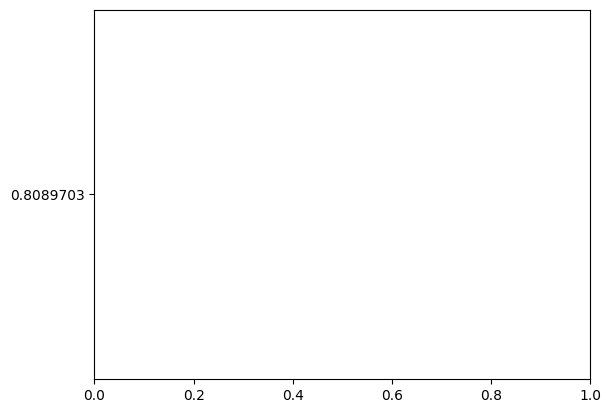

In [29]:
fig, ax = plt.subplots()

ax.plot(x, acc_train)
ax.plot(x, acc_test)

plt.show()

In [15]:
print(len(X))

3


In [16]:
# pmc_trained_model_ptr = my_lib.multi_layer_perceptron_training(
#     w_array_ptr,
#     y_to_predict_ptr,
#     x_to_predict_ptr,
#     len(X),  # number of inputs
#     int(len(X_flat)/len(X)),  # dimension of inputs
#     3,  # number of classes to predict
#     0.5,  # learning rate
#     10,  # epochs
#     layers_ptr_pmc,  # pointeur vers la forme de pmc
#     number_of_layers,  # number of layers
#     True,
# )
#
# pmc_trained_model = np.ctypeslib.as_array(pmc_trained_model_ptr, (7501*3,))
# #print(pmc_trained_model)


In [17]:
# asia_data = np.asarray(asia_new_size)
# greek_data = np.asarray(greek_new_size)
# south_america_data = np.asarray(south_america_new_size)
image_a_predire_data = np.array([predict_asia_data, predict_chateau_data, predict_greek_data],dtype=ctypes.c_float)
image_a_predire_data_flat=image_a_predire_data.flatten()
# new_X = np.array([south_america_data, asia_data, greek_data], dtype=ctypes.c_float)
# new_flat_X = X.flatten()

In [18]:
print(len(image_a_predire_data))
print(len(image_a_predire_data_flat))

3
22500


In [19]:
my_lib.multi_layer_perceptron_predict.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_bool,
]

my_lib.multi_layer_perceptron_predict.restype = ctypes.POINTER(ctypes.c_float)

LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict_mlp = (ctypes.c_float * len(image_a_predire_data_flat))(*image_a_predire_data_flat)
x_to_predict_ptr_mlp = ctypes.cast(x_to_predict_mlp, LP_c_float)

pmc_predict_ptr = my_lib.multi_layer_perceptron_predict(
    pmc_trained_model_accuracy_ptr,  # pointeur vers le modele entrainé
    x_to_predict_ptr_mlp,  # pointeur vers le dataset à prédire
    len(image_a_predire_data),  # nombre d'éléments du dataset
    int(len(image_a_predire_data_flat)/len(image_a_predire_data)),  # dimension des éléments du dataset
    3,  # number of classes to predict
    layers_ptr_pmc,  # pointeur vers la forme de pmc
    number_of_layers,  # number of layers
    True,  # is classification
)

pmc_predict_model = np.ctypeslib.as_array(pmc_predict_ptr, (3 * len(image_a_predire_data),))
# print(pmc_predict_model)
# print(len(X_to_predict))
# print(len(X_to_predict_flat))


In [20]:
for j in range(0,len(pmc_predict_model)-2,3) :
    if pmc_predict_model[j] > pmc_predict_model[j+1] and pmc_predict_model[j] > pmc_predict_model[j+2] :
        print("L'image a deviner vient d'asie")
    elif pmc_predict_model[j+1] > pmc_predict_model[j] and pmc_predict_model[j+1] > pmc_predict_model[j+2] :
        print("L'image a deviner vient de grece")
    elif pmc_predict_model[j+2] > pmc_predict_model[j] and pmc_predict_model[j+2] > pmc_predict_model[j+1]:
        print("L'image a deviner vient d'amerique du sud")
    else :
        print('résultats non concluants')

L'image a deviner vient de grece
résultats non concluants
résultats non concluants


In [23]:
print(pmc_predict_model)

[-0.9992589   0.9996983   0.93401915 -0.99956805  0.9992659   0.8752813
 -0.9994039   0.99961466  0.8829671 ]
